<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# Load Keras-TF model and check predictions

The goal of this notebook is to load a saved Keras model created by Pierre's TF script, then to process a raw Aquaplanet file and get predictions. Finally, we would like to compare the predictions to the target output.

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


## Load the latest model and the corresponding mean and standard deviation files.

In [2]:
model_dir = '/export/home/srasp/TF_models/'

In [3]:
model_fn = 'saved_keras_model_0215.h5'

In [4]:
mean_fn = 'mean_nolat_0213.nc'
std_fn = 'std_nolat_0213.nc'

In [5]:
model = keras.models.load_model(model_dir + model_fn, custom_objects={"tf": tf})

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 9, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 189)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              194560    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
__________

So here is the model which takes 9 input variables with 30 levels each and returns two output variables. In-between we have two fully connected layers with leaky ReLU activations.

In [7]:
mean = nc.Dataset(model_dir + mean_fn)
std = nc.Dataset(model_dir + std_fn)

In [8]:
mean

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): level(30), lats(1), lon(1)
    variables(dimensions): float32 QAP(level,lats,lon), float32 TAP(level,lats,lon), float32 QBP(level,lats,lon), float32 TBP(level,lats,lon), float32 dTdt_adiabatic(level,lats,lon), float32 dQdt_adiabatic(level,lats,lon), float32 SPDT(level,lats,lon), float32 SPDQ(level,lats,lon), float32 TPHYSTND_NORAD(level,lats,lon), float32 PHQ(level,lats,lon), float32 SHFLX(lats,lon), float32 LHFLX(lats,lon), float32 PS(), float32 lat(), float32 SOLIN()
    groups: 

The mean and standard deviation variables have 3 dimensions, but lat and lon only have size 1.

## Load an Aquaplanet file and process as input for NN

These files have been preprocessed with the matlab script to compute derived variables

In [14]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old/'

In [15]:
aqua = nc.Dataset(data_dir + 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc')

In [16]:
aqua

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0_enhance05
    title: 
    logname: tg847872
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    dimensions(sizes): lat(64), lon(128), lev(30), ilev(31), isccp_prs(7), isccp_tau(7), isccp_prstau(49), time(48), tbnd(2), chars(8), crm_x(8), crm_y(1), crm_z(28)
    variables(dimensions): float64 P0(), float64 lat(lat), float64 lon(lon), float64 crm_x(crm_x), float64 crm_y(crm_y), float64 crm_z(crm_z), float64 lev(lev), float64 ilev(ilev), float64 isccp_prs(isccp_prs), float64 isccp_tau(isccp_ta), float64 isccp_prstau(isccp_prsta), float64 time(time), float64 time_bnds(time,tbnd), |S1 date_written(time,chars), |S1 time_written(time,chars), int32 ntrm(), int32 ntrn(), int32 ntrk(), int32 ndbase(), int32 nsbase(), int32 nbdate(), int32 nbsec(), int32 mdt(), int32 

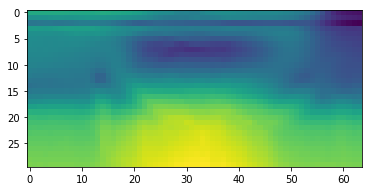

In [17]:
# Let's plot one input and one output variable
plt.imshow(aqua['TBP'][-1, :, :, 0]);

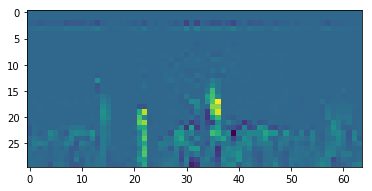

In [18]:
plt.imshow(aqua['TPHYSTND_NORAD'][-1, :, :, 0]);

Now define the input and output variables. They need to be in the right order!

In [27]:
# TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic
#inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
inps = ['TBP','QBP','PS','SOLIN','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic','lat']

In [28]:
outps = ['TPHYSTND_NORAD','PHQ']

The following script takes each variable, normalizes it by subtracting the mean and dividing by the standard deviation. Then the 2D variables (PS) are tiled to fill the 30 levels. We do this for the input and output array.

Note that additionally the vertical axis is flipped.

In [29]:
def convert_ds(ds, vars, nlev=30, normalize=True, flip_vertical=True):
    """Convert to [sample, feature, lev, 1]"""
    arr = []
    for var in vars:
        da = ds[var][:]
        m = mean[var][:]; s = std[var][:]
        if normalize: da = (da - m) / s   # Pierre is normalizing both inputs and outputs. Is that right?
        if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
            a = np.rollaxis(da, 1, 4).reshape(-1, 30)
        elif da.ndim == 3:   # 2D variables [time, lat, lon]
            a = np.rollaxis(np.tile(da.reshape(-1), (30, 1)), 0, 2)
        elif da.ndim == 1:   # lat
            a = np.rollaxis(np.tile(da, (48, 30, 128, 1)), 1, 4).reshape(-1, 30)
        else:
            raise Exception('Incompatible number of dimensions')
        arr.append(a)
    arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
    arr = arr[:, :, -nlev:]
    if flip_vertical: arr = arr[:, :, ::-1]   # I think this should be true for inputs and outputs
    return arr

In [30]:
# First check whether we did the transformations correct by looking at the 
# non-normalized output
inp_arr_nonnorm = convert_ds(aqua, inps, nlev=21, normalize=False)

In [31]:
inp_arr_nonnorm.shape   # [sample, feature, lev, 1]

(393216, 9, 21, 1)

In [32]:
def unravel(x, nlev=30):
    """Convert back from [sample] to [time, lat, lon]"""
    return x.reshape(48, 64, 128, -1, nlev)

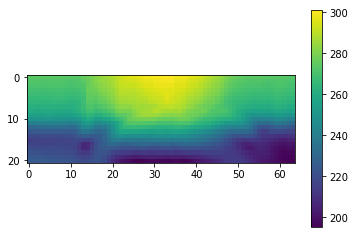

In [33]:
plt.imshow(unravel(inp_arr_nonnorm, nlev=21)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [34]:
# Now check out the normalized output
inp_arr = convert_ds(aqua, inps, nlev=21)

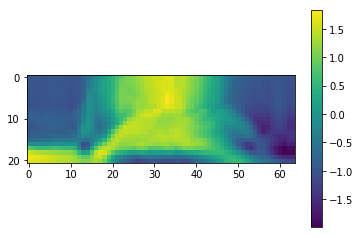

In [36]:
plt.imshow(unravel(inp_arr, nlev=21)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

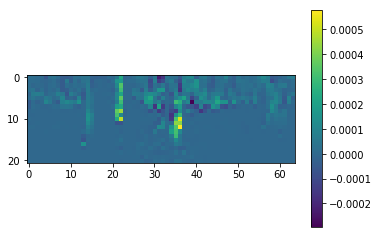

In [37]:
# Check the non-normalized version of the output array
plt.imshow(unravel(convert_ds(aqua, outps, nlev=21, normalize=False), nlev=21)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

In [38]:
# Now also normalize the output array
outp_arr = convert_ds(aqua, outps, nlev=21)

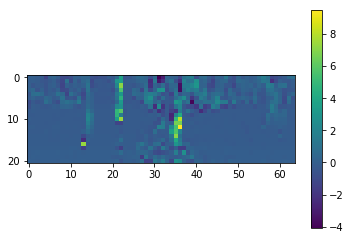

In [39]:
plt.imshow(unravel(outp_arr, nlev=21)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

## Get model predictions

We will now use the normalized input array and check out the predictions

In [40]:
inp_arr.shape

(393216, 9, 21, 1)

In [41]:
preds = model.predict(inp_arr, batch_size=1024)

In [42]:
preds.shape, outp_arr.shape

((393216, 2, 21, 1), (393216, 2, 21, 1))

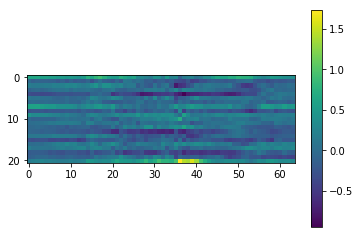

In [45]:
# First, check the raw predictions which should match the normalized outputs
plt.imshow(unravel(preds, nlev=21)[-1, :, 0, 0, :].T); # Vertical axis is flipped.
plt.colorbar();

So something is off here. Maybe I messed up the input processing. The order of the input variables could be wrong...

## Old stuff

In [69]:
def unravel(x, nlev=30):
    return x.reshape(48, 64, 128, -1, nlev)

In [20]:
def denorm(arr, vars, nlev=30):
    # Inputs [sample, feature, lev, 1]
    a = np.copy(arr)
    a = a.reshape(48, 64, 128, -1, nlev)  # [time, lat, lon, feature, lev]
    for i, var in enumerate(vars):
        m = np.rollaxis(mean[var][-nlev:][::-1], 0, 3) 
        s = np.rollaxis(std[var][-nlev:][::-1], 0, 3) 
        a[:, :, :, i, :] = a[:, :, :, i, :] * s + m
    return a

In [21]:
preds_de = denorm(preds, outps); preds_de.shape

(48, 64, 128, 2, 30)

In [22]:
out_de = denorm(outp_arr, outps)

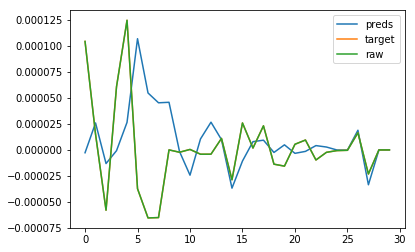

In [63]:
plt.plot(preds_de[4, 30, 60, 0, :], label='preds')
plt.plot(out_de[4, 30, 60, 0, :], label='target')
plt.plot(aqua['TPHYSTND_NORAD'][4, ::-1, 30, 60], label='raw')
plt.legend();

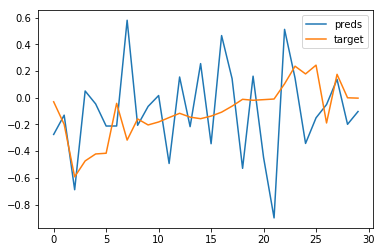

In [68]:
plt.plot(preds[0, 0, :, 0], label='preds')
plt.plot(outp_arr[0, 0, :, 0], label='target')
plt.legend();

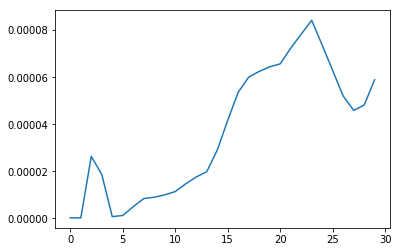

In [77]:
plt.plot(std['TPHYSTND_NORAD'][:, 0, 0])

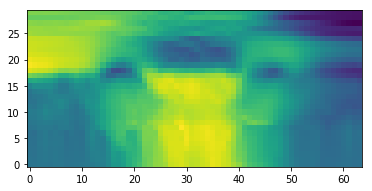

In [83]:
plt.imshow(
    unravel(inp_arr)[-1, :, 38, 0, :].T,
    origin='lower')

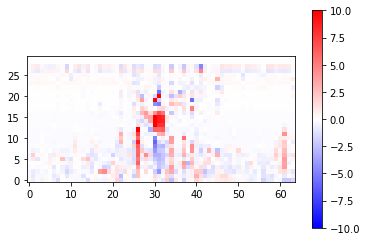

In [84]:
plt.imshow(
    unravel(outp_arr)[-1, :, 38, 0, :].T, 
    origin='lower', cmap='bwr', vmin=-10, vmax=10)
plt.colorbar()

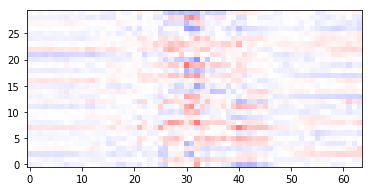

In [85]:
plt.imshow(
    unravel(preds)[-1, :, 38, 0, :].T, 
    origin='lower', cmap='bwr', vmin=-5, vmax=5)

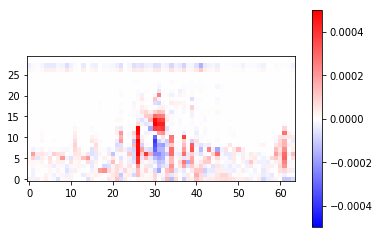

In [86]:
plt.imshow(out_de[-1, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)
plt.colorbar()

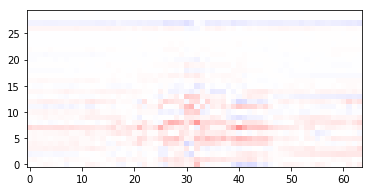

In [87]:
plt.imshow(preds_de[-1, :, 38, 0, :].T, origin='lower', cmap='bwr', vmin=-5e-4, vmax=5e-4)

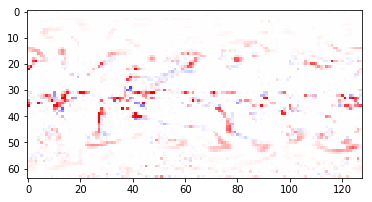

In [88]:
plt.imshow(out_de[-1, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)

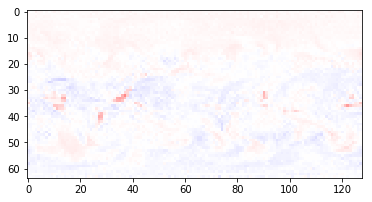

In [89]:
plt.imshow(preds_de[-1, :, :, 0, 10], cmap='bwr', vmin=-5e-4, vmax=5e-4)